<h1> Udacity Guided Project : I94 immigration, Temprature and Airport data analysis <\h1>
# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### <h4> <br>Step 1: Scope the Project and Gather Data</br> </h4>
<h4><br>Scope </br>
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? </br></h4>
##### In this project I will be using pyspark and python plotly on the I94 in order to data ingest, arrange, clean, prepare, analyze & visualize the trends in the data<
<br>
##### <h4> Describe and Gather Data </h4>
##### <br>Describe the data sets you're using. Where did it come from? What type of information is included?  </br>

##### i94 Immigration Sample Data : sample data which is from the US National Tourism and Trade Office. This data comes from the US National Tourism and Trade Office. This table is used for the fact table in this project.

##### World Temperature Data world_temperature. This dataset contains temperature data of various cities from 1700’s – 2013. This dataset came from Kaggle. This table is not used because the data is available until 2013

##### U.S. City Demographic Data us-cities-demographics. This dataset contains population details of all US Cities and census-designated places includes gender & race information. This data came from OpenSoft. The table is grouped by state to get aggregated statistics.

##### Airport Codes is a simple table of airport codes and corresponding cities. The rows where IATA codes are available in the table are selected for this project.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *
from pyspark.sql import Row

from pyspark.sql.functions import date_add as d_add
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import year, month, dayofmonth, weekofyear, date_format

import plotly.plotly as py
import plotly.graph_objs as go
import requests
import urllib.request
requests.packages.urllib3.disable_warnings()

In [2]:
# Create configparser Object
config = configparser.ConfigParser()
# Read Config File
config.read('dl.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

****A SparkSession can be used create DataFrame, register DataFrame as tables, execute SQL over 
tables, cache tables, and read parquet files. To create a SparkSession, use the following builder 
pattern:

In [3]:
#Initial Spark Session
spark = SparkSession.builder.\
    config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
i94_df =spark.read.format('com.github.saurfang.sas.spark').load(fname)

In [6]:
spark

<h3><br>Step 2: Explore and Assess the Data </br></h3>
<h4><br>Explore the Data</br></h4>
Data Explorations performed using the .printSchema() method to print the inferred schema associated with the data. 
Notice that we have 28 columns (which is expected based on our format information) and column names are well laid out, datatypes are present but something can be set right based on the nature of the data, and each field is nullable. 
Note: .printSchema() is also a Spark action.

In [7]:
i94_df.printSchema()
tuple_df =i94_df.schema

for d in tuple_df:
    print(d)
    

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [10]:
import os
import configparser
import pandas as pd
import glob

from pyspark.sql import SparkSession


class DataUtils(object):
    " The class consists of pre-processing methods"
    
    def read_config(self,file_name):
        config = configparser.ConfigParser()
        conf_file=config.read(file_name)
        get_sections =[]
        get_values=[]
        for section_name in config.sections():
                #print(f"Section Name is {section_name}")
                get_sections.append(section_name)
                #print(get_sections)
                #print('Options:', config.options(section_name))
                for key, value in config.items(section_name):
                    get_values.append(value)
                #print(get_values)
                collect_pkg_name=get_values[0]
                collect_lib_name=get_values[1]
                print(collect_pkg_name,collect_lib_name)
                return collect_pkg_name  ,collect_lib_name    
    '''
    def create_spark_session():
        "Function to create spark session"
        collect_pkg_name, collect_lib_name = self.read_config("config.ini")
        
        
        print(f"Spark Package Name is :{pkg_name} and Library name is {lib_name}")
        spark = SparkSession \
                .builder \
                .config(collect_pkg_name +","+ collect_lib_name) \
                .enableHiveSupport() \
                .getOrCreate()
        spark
        return spark, pkg_name, lib_name
    '''
    
    def create_spark_session():
        spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11") \
        .enableHiveSupport() \
        .getOrCreate()
        return spark    

    def read_immigration_file_from_path(self,filepath):
        """ The Function to read the files from path"""
        all_files = []
        for root, dirs, files in os.walk(filepath):
            files = glob.glob(os.path.join(root,'i94_apr16_sub.sas7bdat'))
            
            files_non_apr = glob.glob('./data/18-83510-I94-Data-2016/' + '*.sas7bdat')
            
            all_files = [file for file in files_non_apr if ("apr16" not in file)]
            print(files[0])
            file_name=files[0]
            for f in files :
                all_files.append(os.path.abspath(f))

    # Get total number of files found 
        num_files = len(all_files)
        print('Matching {} files found in {} and name of the file is {} and all other file {}'.format(num_files, filepath, file_name, all_files))
        return filepath,file_name, all_files
    
    def load_i94_data(file_name):
        """
        Ingests i94 data for the year 2016 from 12, monthly SAS files
        """
        file_name =read_immigration_file_from_path(self,filepath)
        spark = create_spark_session()
        spark
        i94_df =spark.read.format('com.github.saurfang.sas.spark').load(filepath)
        print( i94_df.printSchema())
                  
def main(): 

    utils = DataUtils()
    utils.read_config('config.ini')
    
    
    utils.read_immigration_file_from_path('../../data/18-83510-I94-Data-2016/')
    #print(spark_sess)
    collect_pkg_name,collect_lib_name=utils.read_config('config.ini')
    print(collect_pkg_name,collect_lib_name)
    utils.create_spark_session
    utils.load_i94_data
    
if __name__=="__main__":
    main()
    


"spark.jars.packages" "saurfang:spark-sas7bdat:2.0.0-s_2.11"
../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat
Matching 1 files found in ../../data/18-83510-I94-Data-2016/ and name of the file is ../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat and all other file ['/data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat']
"spark.jars.packages" "saurfang:spark-sas7bdat:2.0.0-s_2.11"
"spark.jars.packages" "saurfang:spark-sas7bdat:2.0.0-s_2.11"


<h4>Identify data quality issues, like missing values, duplicate data, etc.</h4>

We have created the dataframe for the initial analysis. i94_df dataframe has .show()method with 
the truncate option to False so we can see all the DataFrame columns and content. 

In [11]:
i94_df.show(10, truncate=False)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|cicid|i94yr |i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear|dtaddto |gender|insnum|airline|admnum        |fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|6.0  |2016.0|4.0   |692.0 |692.0 |XXX    |20573.0|null   |null   |null   |37.0  |2.0    |1.0  |null    |null    |null |T      |null   |U      |null   |1979.0 |10282016|null  |null  |null   |1.897628485E9 |null |B2      |
|7.0  |2016.0|4.0   |254.0 |276.0 |ATL    |20551.0|1.0    |AL     |null   |25.0  |3.0    |1.0  |20130811|SEO    

***Let us count the columns in our dataset

In [10]:
columns_in_file=len(i94_df.columns)
rows_in_file=i94_df.count()
distinct_rows_data=i94_df.distinct().count()
print(f"The total number of columns in the data file are {columns_in_file} and number of rows {rows_in_file} ")
print(f"Count of distinct number of rows {distinct_rows_data} ")

The total number of columns in the data file are 28 and number of rows 3096313 
Count of distinct number of rows 3096313 


In [11]:
i94_df.select(["cicid","count"]).filter(i94_df["count"] == 0).limit(10).toPandas()

,cicid,count


In [12]:
i94_df.groupBy("i94port").count().show()

+-------+-----+
|i94port|count|
+-------+-----+
|    FMY|17514|
|    BGM|  128|
|    HEL|    2|
|    DNS|   35|
|    MOR|   14|
|    FOK|   14|
|    HVR|   45|
|    SNA| 7066|
|    PTK|   12|
|    SPM|16973|
|    CLG| 3191|
|    OPF|  909|
|    DLB|   12|
|    ABS|    4|
|    NAS|13032|
|    MYR|    5|
|    PVD|  352|
|    OAK| 3501|
|    FAR|    5|
|    OTT|  663|
+-------+-----+
only showing top 20 rows



<h3> Cleaning data </h3>
<h6> =======================================================================================</h6>
<h4> <br>In data cleaning process We are converting requiredcolumn into integer from double</br>
 <br>Renaming few columns to make it more meaningful.</br> 
  <br>Dropping the columns from the dataFrame </br></h4>
<h4>Below are different transformation I have added</h4>
<h4><br> 1.cicid cast converted to integer</br>
<br>2.i94yr,i94mon, has been changed to year, month respectively with cast converted to integer</br>
<br>3.We dropped the column after renaming them and used the renamed one.</br>
<br>4.One of the transformation which I have used is usage of CASE expression and WHEN in the pyspark while data cleaning process</br>
<br>5.As we see the flight number is inconsistent in some places, the total length is varchar(5) and in some places the string just have two digits flight number.  In order keep the consistency in the values we are padding the 0 on th eleft of each flight number making it more consistent</br>
</h4>


In [ ]:
from pyspark.sql.functions import expr 
from pyspark.sql.functions import to_date
from pyspark.sql import functions as F
from pyspark.sql.functions import *
i94_df_withColum_transformation = i94_df \
.withColumn("document_number", col("cicid").cast("integer")) \
.withColumn("year", col("i94yr").cast("integer")) \
.drop("i94yr") \
.withColumn("month", col("i94mon").cast("integer")) \
.drop("i94mon") \
.withColumn("bornCountry", col("i94cit").cast("integer")) \
.drop("i94cit") \
.withColumn("residentCountry", col("i94res").cast("integer")) \
.drop("i94res") \
.withColumnRenamed("i94port", "arrivalPort") \
.withColumn("mode",col("i94mode")) \
.withColumn("modeofTransportation", col("i94mode").cast("integer")) \
.withColumn("modeofTransportation",\
            expr("CASE WHEN i94mode == 1.0 THEN  'Air' WHEN i94mode == 2.0 THEN  'Sea' WHEN i94mode == 3.0 THEN  'Land' WHEN i94mode == 9.0 THEN  'Not Reported' ELSE 'other' END AS mode_of_transportation_desc"))\
.drop("i94mode") \
.withColumnRenamed("i94addr", "arrivalAddress") \
.withColumn("age", col("i94bir").cast("integer")) \
.drop("i94bir") \
.withColumn("visa", col("i94visa").cast("integer")) \
.withColumn('i94visa_desc',\
            F.when(col("i94visa") == 1, 'Business')\
             .when(col("i94visa") == 2, 'Pleasure')\
             .when(col("i94visa") == 3, 'Student')\
             .otherwise('Other'))\
.drop("i94visa") \
.withColumnRenamed("entdepa", "arrivalFlag") \
.withColumnRenamed("entdepd", "departureFlag") \
.withColumnRenamed("entdepu", "updateFlag") \
.withColumnRenamed("matflag", "matchFlag") \
.withColumn("birthYear", col("biryear").cast("integer")) \
.drop("biryear") \
.withColumnRenamed("fltno", "flightNumber") \
.withColumn("flightNumber" ,\
           expr("CASE WHEN length(flightNumber) < 5 THEN lpad(flightNumber,5,'0') ELSE flightNumber END AS flightNumber "))\
.withColumnRenamed("visaType", "visaType") \
.withColumn("sasDate", to_date(lit("01/01/1960"), "MM/dd/yyyy")) \
.withColumn("arrivalDate", expr("date_add(sasDate, arrdate)")) \
.withColumn("departureDate", expr("date_add(sasDate, depdate)")) \
.withColumn("totalDaysStay", (datediff(to_date("departureDate"),to_date("arrivalDate")) ))\
.drop( "sasDate","arrdate", "depdate", "count", "admnum", "dtadfile", "visapost", "occup", "dtaddto", "insnum")
i94_df_withColum_transformation.limit(10).toPandas()

In [13]:
from pyspark.sql.types import *
import pyspark.sql as sql
import pyspark.sql.functions as f
from pyspark.sql.functions import datediff, to_date, lit

i94_new_dataframe=spark.createDataFrame(i94_df_withColum_transformation.filter(~col('arrivalPort').isin(['XXX'])).limit(2).toPandas()).collect()
#i94_new_dataframe_filter = i94_new_dataframe.filter(~col('arrivalPort').isin(['XXX'])).show()
print(i94_new_dataframe)
# We will be iterating thru the row object 
for row in i94_new_dataframe:
    print(str(row['cicid']) + "," + row['arrivalPort'] + "," + str(row['visaType']) +"," + str(row['visa']) +"," + str(row["arrivalFlag"]))
# Note : Loading the whole dataFrame might cause the memory error based on the size of the 
# OS configuration hence we are using limit(5) while creating the dataFrame

[Row(cicid=7.0, arrivalPort='ATL', arrivalAddress='AL', arrivalFlag='G', departureFlag=None, updateFlag='Y', matchFlag=None, gender='M', airline=None, flightNumber='00296', visaType='F1', document_number=7, year=2016, month=4, bornCountry=254, residentCountry=276, modeofTransportation='Air', age=25, visa=3, i94visa_desc='Student', birthYear=1991, arrivalDate=datetime.date(2016, 4, 7), departureDate=None, totalDaysStay=nan), Row(cicid=15.0, arrivalPort='WAS', arrivalAddress='MI', arrivalFlag='T', departureFlag='O', updateFlag=None, matchFlag='M', gender='M', airline='OS', flightNumber='00093', visaType='B2', document_number=15, year=2016, month=4, bornCountry=101, residentCountry=101, modeofTransportation='Air', age=55, visa=2, i94visa_desc='Pleasure', birthYear=1961, arrivalDate=datetime.date(2016, 4, 1), departureDate=datetime.date(2016, 8, 25), totalDaysStay=146.0)]
7.0,ATL,F1,3,G
15.0,WAS,B2,2,T


### Data Preparation step 1 : Check Duplicates row duplicate

In [13]:
get_duplicates_at_row_df=i94_df_withColum_transformation.groupby(i94_df_withColum_transformation.columns).count().filter('count >1').show()

+-----+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------------------+---+----+------------+---------+-----------+-------------+-------------+-----+
|cicid|arrivalPort|arrivalAddress|arrivalFlag|departureFlag|updateFlag|matchFlag|gender|airline|flightNumber|visaType|document_number|year|month|bornCountry|residentCountry|modeofTransportation|age|visa|i94visa_desc|birthYear|arrivalDate|departureDate|totalDaysStay|count|
+-----+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------------------+---+----+------------+---------+-----------+-------------+-------------+-----+
+-----+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------

### Data Preparation step 2 : Check Duplicates  duplicate by not including cicid column.
#### In below we first group by columns excluding the more unique column which in our case is cicid

In [16]:
get_dups_without_unique_col=i94_df_withColum_transformation.groupby([col for col in i94_df_withColum_transformation.columns if col != 'cicid' ]).count().filter('count >1').show()

+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------------------+---+----+------------+---------+-----------+-------------+-------------+-----+
|arrivalPort|arrivalAddress|arrivalFlag|departureFlag|updateFlag|matchFlag|gender|airline|flightNumber|visaType|document_number|year|month|bornCountry|residentCountry|modeofTransportation|age|visa|i94visa_desc|birthYear|arrivalDate|departureDate|totalDaysStay|count|
+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------------------+---+----+------------+---------+-----------+-------------+-------------+-----+
+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------------------+---+----+--

### Data Preparation Step 3 : Check the distincts 
#### It looks like we do not have any such a observation for our cicid column

In [20]:
i94_df_withColum_transformation.agg(f.count('cicid').alias('CounofCicid'), f.countDistinct('cicid').alias('CountOfDistinctCicid')).show()

+-----------+--------------------+
|CounofCicid|CountOfDistinctCicid|
+-----------+--------------------+
|    3096313|             3096313|
+-----------+--------------------+



### Data Prepartion Step 4: Missing Observations

###### Missing observations per row : To calculate how much amount of data is missing from a ROW, it is easier to work with RDDs as we can loop through each RDD's record and count how many values are missing
        First access .rdd within our data frame i94_new_dataframe
        Using .map transformation to the row object of RDDs into Dictionary 
        Since we are working with RDDs, we want to retain all the other columns. Thus,
        we first convert the row (which is a Row(...) object) into a dictionary using the .asDict()         method, so then we can later unpack it using **

In [14]:
rdd = spark.sparkContext.parallelize(i94_new_dataframe)
rdd.take(1)
rdd.map(lambda row: sql.Row(
        **row.asDict()
        , total_stay=row.totalDaysStay
        ) ).toDF().select(i94_df_withColum_transformation.columns + [ 'total_stay']).show()

+-----+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------------------+---+----+------------+---------+-----------+-------------+-------------+----------+
|cicid|arrivalPort|arrivalAddress|arrivalFlag|departureFlag|updateFlag|matchFlag|gender|airline|flightNumber|visaType|document_number|year|month|bornCountry|residentCountry|modeofTransportation|age|visa|i94visa_desc|birthYear|arrivalDate|departureDate|totalDaysStay|total_stay|
+-----+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+---------------+----+-----+-----------+---------------+--------------------+---+----+------------+---------+-----------+-------------+-------------+----------+
|  7.0|        ATL|            AL|          G|         null|         Y|     null|     M|   null|       00296|      F1|              7|2016|    4|        254|         

In [16]:
# missing values % from each columns
import pyspark.sql.functions as fn
i94_df_withColum_transformation.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in i94_df_withColum_transformation.columns
]).toPandas()

,cicid_missing,arrivalPort_missing,arrivalAddress_missing,arrivalFlag_missing,departureFlag_missing,updateFlag_missing,matchFlag_missing,gender_missing,airline_missing,flightNumber_missing,...,bornCountry_missing,residentCountry_missing,modeofTransportation_missing,age_missing,visa_missing,i94visa_desc_missing,birthYear_missing,arrivalDate_missing,departureDate_missing,totalDaysStay_missing
0,0.0,0.0,0.049282,0.000077,0.044708,0.999873,0.044708,0.133794,0.027009,0.006314,...,0.0,0.0,0.0,0.000259,0.0,0.0,0.000259,0.0,0.046009,0.046009


In [33]:
print("New Immigration data schema:")
i94_df_withColum_transformation.printSchema()

New Immigration data schema:
root
 |-- cicid: integer (nullable = true)
 |-- arrivalPort: string (nullable = true)
 |-- arrivalAddress: string (nullable = true)
 |-- arrivalFlag: string (nullable = true)
 |-- departureFlag: string (nullable = true)
 |-- updateFlag: string (nullable = true)
 |-- matchFlag: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- flightNumber: string (nullable = true)
 |-- visaType: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- bornCountry: integer (nullable = true)
 |-- residentCountry: integer (nullable = true)
 |-- modeofTransportation: string (nullable = false)
 |-- age: integer (nullable = true)
 |-- visa: integer (nullable = true)
 |-- i94visa_desc: string (nullable = false)
 |-- birthYear: integer (nullable = true)
 |-- arrivalDate: date (nullable = true)
 |-- departureDate: date (nullable = true)
 |-- totalDaysStay: integer (nullable = tru

<h4>The .toPandas() function converts a spark dataframe into a pandas Dataframe 
which is easier to show.</h4>

In [34]:
i94_df_withColum_transformation.limit(5).toPandas()

,cicid,arrivalPort,arrivalAddress,arrivalFlag,departureFlag,updateFlag,matchFlag,gender,airline,flightNumber,...,bornCountry,residentCountry,modeofTransportation,age,visa,i94visa_desc,birthYear,arrivalDate,departureDate,totalDaysStay
0,6,XXX,None,T,None,U,None,None,None,None,...,692,692,other,37,2,Pleasure,1979,2016-04-29,None,NaN
1,7,ATL,AL,G,None,Y,None,M,None,00296,...,254,276,Air,25,3,Student,1991,2016-04-07,None,NaN
2,15,WAS,MI,T,O,None,M,M,OS,00093,...,101,101,Air,55,2,Pleasure,1961,2016-04-01,2016-08-25,146.0
3,16,NYC,MA,O,O,None,M,None,AA,00199,...,101,101,Air,28,2,Pleasure,1988,2016-04-01,2016-04-23,22.0
4,17,NYC,MA,O,O,None,M,None,AA,00199,...,101,101,Air,4,2,Pleasure,2012,2016-04-01,2016-04-23,22.0


<h3>Additional Check : Checking the Schema for the above file loaded into Spark </h3>

In [51]:
## File Name validate_setup.py
## Addition Verification step Custome function created to check if directory exits
import os
import shutil
import glob
'''
    Function to check if the directory used
    to write the parquet data is present if not
    create one and add parquet file
    
    Parameters : 
        folder_name : Pass the value for folder_name
        parquet_file_name : Pass the filename with .parquet extention
        
'''

def parquet_check_n_create(folder_name, parquet_store_name):
    try:
        if os.path.isdir(folder_name) == False:
            print(f"FolderNameCheck::The {folder_name} does not exits...!! Creating {folder_name}")
            i94_df.write.parquet(folder_name +"/" + parquet_store_name)
        else:
            shutil.rmtree(folder_name)
            i94_df.write.parquet(folder_name +"/" + parquet_store_name)
            print(f"FolderNameCheck:The {folder_name} does exits...!! Using existing {folder_name}")
    except:
       
        print("Something went wrong")
    else:
        print("Nothing went wrong")
        
#if __name__=="__main__":
#    check_if_spark_dir_exists('_sas_data','i94_df.parquet')


<h3>Step 3: Define the Data Model</h3>
*****3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

For the purpose of this project we will be using the STAR schema or model close to star schema. Using STAR schema we will be in position to normalize our data sets and also build a strong relationship by defining and implementing the relationships using primary, foreging keys etc.

Below is the conceptualize data model

![alt text](CapstoneDataModel.png "Title")

*****3.2 Mapping Out Data Pipelines

****Step 1 : First we will be loading our data file under ../data/ folder
Step 2: Read the file in SparkDataFrame
Step 3: Clean the file


# Data dictionary
<table style="width:50%">
<tr>
<th>ColumnName</th>
<th>Description</th>
</tr>

<tr>
    <td>cicid </td>
    <td>Unique record ID</td>
</tr>
<tr>
    <td>i94yr </td>
    <td>4 digit year</td>
</tr>
<tr>
    <td>i94mon</td>
    <td>Numeric month</td>
    </tr>
<tr>
    <td>i94cit3</td>
    <td>digit code for immigrant country of birth</td>
</tr>
<tr>
    <td>i94res</td>
    <td>3 digit code for immigrant country of residence </td> </tr>
<tr>
    <td>i94port</td>
    <td>Port of admission</td>
</tr>
    <tr><td>arrdate</td><td> Arrival Date in the USA</td></tr>
<tr><td>i94mode</td><td> Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</td></tr>
<tr><td>i94addr</td><td> USA State of arrival</td></tr>
<tr><td>depdate</td><td> Departure Date from the USA</td></tr>
<tr><td>i94bir</td><td> Age of Respondent in Years</td></tr>
<tr><td>i94visa</td><td> Visa codes collapsed into three categories</td></tr>
<tr><td>count</td><td> Field used for summary statistics</td></tr>
<tr><td>dtadfile</td><td> Character Date Field - Date added to I-94 Files</td></tr>
<tr><td>visapost</td><td> Department of State where where Visa was issued</td></tr>
<tr><td>occup</td><td> Occupation that will be performed in U.S</td></tr>
<tr><td>entdepa</td><td> Arrival Flag - admitted or paroled into the U.S.</td></tr>
<tr><td>entdepd</td><td> Departure Flag - Departed, lost I-94 or is deceased</td></tr>
<tr><td>entdepu</td><td> Update Flag - Either apprehended, overstayed, adjusted to perm residence</td></tr>
<tr><td>matflag</td><td> Match flag - Match of arrival and departure records</td></tr>
<tr><td>biryear</td><td> 4 digit year of birth</td></tr>
<tr><td>dtaddto</td><td> Character Date Field - Date to which admitted to U.S. (allowed to stay until)</td></tr>
<tr><td>gender</td><td> Non-immigrant sex</td></tr>
<tr><td>insnum</td><td> INS number</td></tr>
<tr><td>airline</td><td> Airline used to arrive in U.S.</td></tr>
<tr><td>admnum</td><td> Admission Number</td></tr>
<tr><td>fltno</td><td> Flight number of Airline used to arrive in U.S.</td></tr>
<tr><td>visatype</td><td> Class of admission legally admitting the non-immigrant to temporarily stay in U.S.</td></tr>
    </table>

<h4> Count Total number of rows in I_94 SAS data set <h4>

In [13]:
Tot_number_of_rows_in_i94_df = i94_df_withColum_transformation.count()
print(f"There are {Tot_number_of_rows_in_i94_df} total lines in the file")

There are 3096313 total lines in the file


In [14]:
# Check the duplicate in Unique Records
i94_df_2 = i94_df_withColum_transformation.select(['cicid']).count()
print(i94_df_2)

3096313


In [45]:
i94_df_post_duplicate_removal =i94_df_withColum_transformation.dropDuplicates(['cicid'])
i94_df_post_duplicate_removal.count()

3096313

<H5> Data Exploration: 
 Explore different modes of transportations 
 Distinct Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported
 We see in below data there are nulls present for this field and we have added not reported in place of nulls<h5>

In [15]:
i94_df_withColum_transformation.select(['modeofTransportation']).distinct().show()

+--------------------+
|modeofTransportation|
+--------------------+
|        Not Reported|
|                 Sea|
|               other|
|                Land|
|                 Air|
+--------------------+



### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
### Build the data pipelines to create the data model.
### Implementing the dimentionalize mode based on above model in step 3

###### Data Model Implementation

<h2>dim_visa_category</h2>
<h3>Table to hold the visa category information of he travelers</h3>

In [31]:
from pyspark.sql import functions as F

dim_visa_category= i94_df_withColum_transformation.select(['visaType']).alias('visaCatType').distinct()

dim_visa_category = dim_visa_category \
                    .withColumn('visaCategoryID', monotonically_increasing_id())
dim_visa_category = dim_visa_category.select(['visaCategoryID','visaType'])  
dim_visa_category = dim_visa_category.withColumn('visaCateogryDesc', \
                    when(col("visaType").startswith("F"),"Educational Visa") \
                    .when(col("visaType").isin("B1","B2"), "Business Sponsor visa").otherwise("UNK").cast("string") ) 
                    

dim_visa_category.show()
dim_visa_category.printSchema()   
#dim_visa_category.write.parquet("_sas_data_visa_cat/dim_visa_category.parquet")
parquet_check_n_create("_sas_data_visa_cat","dim_visa_category.parquet")

+--------------+--------+--------------------+
|visaCategoryID|visaType|    visaCateogryDesc|
+--------------+--------+--------------------+
|  103079215104|      F2|    Educational Visa|
|  352187318272|     GMB|                 UNK|
|  369367187456|      B2|Business Sponsor ...|
|  498216206336|      F1|    Educational Visa|
|  601295421440|     CPL|                 UNK|
|  704374636544|      I1|                 UNK|
|  738734374912|      WB|                 UNK|
|  747324309504|      M1|                 UNK|
|  807453851648|      B1|Business Sponsor ...|
|  884763262976|      WT|                 UNK|
| 1151051235328|      M2|                 UNK|
| 1314259992576|      CP|                 UNK|
| 1331439861760|     GMT|                 UNK|
| 1348619730944|      E1|                 UNK|
| 1391569403904|       I|                 UNK|
| 1554778161152|      E2|                 UNK|
| 1709396983808|     SBP|                 UNK|
+--------------+--------+--------------------+

root
 |-- vi

<h2>dim_arrival_port</h2>
<h3> Table to store the arrival data for the travelers</h3>

In [27]:
from pyspark.sql import functions as F


dim_arrival_port = i94_df_withColum_transformation \
              .withColumn('port_id', monotonically_increasing_id()) \
              .withColumn('port_nm', col('arrivalPort')) \
              .withColumn('State',col('arrivalAddress') )

dim_arrival_port = dim_arrival_port.select(['port_id','port_nm','State'])  
                    

dim_arrival_port.show()
dim_arrival_port.printSchema()   
parquet_check_n_create("_sas_data_arrival_port","dim_arrival_port.parquet")

+-------+-------+-----+
|port_id|port_nm|State|
+-------+-------+-----+
|      0|    XXX| null|
|      1|    ATL|   AL|
|      2|    WAS|   MI|
|      3|    NYC|   MA|
|      4|    NYC|   MA|
|      5|    NYC|   MI|
|      6|    NYC|   NJ|
|      7|    NYC|   NJ|
|      8|    NYC|   NY|
|      9|    NYC|   NY|
|     10|    NYC|   NY|
|     11|    TOR|   MO|
|     12|    BOS|   MA|
|     13|    ATL|   MA|
|     14|    ATL|   MA|
|     15|    ATL|   NJ|
|     16|    ATL|   NY|
|     17|    HOU|   TX|
|     18|    NYC|   CT|
|     19|    NYC|   CT|
+-------+-------+-----+
only showing top 20 rows

root
 |-- port_id: long (nullable = false)
 |-- port_nm: string (nullable = true)
 |-- State: string (nullable = true)

FolderNameCheck:The _sas_data_arrival_port does exits...!! Using existing _sas_data_arrival_port
Nothing went wrong


### dim_mode_transportations

In [21]:
from pyspark.sql import functions as F


dim_mode_transportation = i94_df_withColum_transformation \
              .withColumn('mode_id', monotonically_increasing_id()) \
              .withColumn('mode', col('mode')) \
              .withColumn('modeOfTransportations',col('modeOfTransportation') )

dim_mode_transportation = dim_mode_transportation.select(['mode_id','mode','modeOfTransportation'])  
                    

dim_mode_transportation.toPandas()
dim_mode_transportation.printSchema()   
parquet_check_n_create("_sas_mode_of_transp","dim_mode_transportation.parquet")

root
 |-- mode_id: long (nullable = false)
 |-- mode: double (nullable = true)
 |-- modeOfTransportation: string (nullable = false)

FolderNameCheck::The _sas_mode_of_transp does not exits...!! Creating _sas_mode_of_transp
Nothing went wrong


<h3>Load/Staging : dim_visa_category</h3>

In [32]:
#Drop table tempview if exist
spark.catalog.dropTempView('dim_visa_category')
# Load the temp view
load_temp_data =spark.sql("CREATE TEMPORARY VIEW dim_visa_category USING parquet OPTIONS (path \"_sas_data_visa_cat/dim_visa_category.parquet\")")
# select from temp view
spark.sql("SELECT * FROM dim_visa_category").show(2)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1976.0|10292016|     F|  null|     QF|9.495387003E10|00011|      B1|
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  

<h3>Load/Staging : dim_arrival_port</h3>

In [11]:

#Drop table tempview if exist
spark.catalog.dropTempView('dim_arrival_port')
# Load the temp view
load_temp_data =spark.sql("CREATE TEMPORARY VIEW dim_arrival_port USING parquet OPTIONS (path \"_sas_data_arrival_port/dim_arrival_port.parquet\")")
# select from temp view
spark.sql("SELECT * FROM dim_arrival_port").show(3)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1976.0|10292016|     F|  null|     QF|9.495387003E10|00011|      B1|
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  

<h3>Loading/Staging : dim_mode_transportation</h3>

In [25]:

#Drop table tempview if exist
spark.catalog.dropTempView('dim_mode_transportaion')
# Load the temp view
load_temp_data =spark.sql("CREATE TEMPORARY VIEW dim_mode_transportaion USING parquet OPTIONS (path \"_sas_mode_of_transp/dim_mode_transportation.parquet\")")
# select from temp view
spark.sql("SELECT * FROM dim_mode_transportaion").show(3)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1976.0|10292016|     F|  null|     QF|9.495387003E10|00011|      B1|
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  

<h3> dim_time</h3>

In [15]:
dim_time = i94_df_withColum_transformation.select(['arrivalDate'])\
                    .withColumnRenamed('arrivalDate','time') 

dim_time_tbl = dim_time \
             .withColumn('day', F.dayofmonth('time')) \
             .withColumn('month', F.month('time')) \
             .withColumn('year', F.year('time')) \
             .withColumn('week', F.weekofyear('time')) \
             .withColumn('weekday', F.dayofweek('time'))\
             .dropDuplicates()
    
#dim_time_tbl.write.parquet("_sas_data_time_dim/time_dim.parquet")
parquet_check_n_create("_sas_data_time_dim","time_dim.parquet")
dim_time_tbl.limit(10).toPandas()
    

FolderNameCheck:The _sas_data_time_dim does exits...!! Using existing _sas_data_time_dim
Nothing went wrong


,time,day,month,year,week,weekday
0,2016-04-01,1,4,2016,13,6
1,2016-04-06,6,4,2016,14,4
2,2016-04-11,11,4,2016,15,2
3,2016-04-28,28,4,2016,17,5
4,2016-04-16,16,4,2016,15,7
5,2016-04-10,10,4,2016,14,1
6,2016-04-09,9,4,2016,14,7
7,2016-04-07,7,4,2016,14,5
8,2016-04-05,5,4,2016,14,3
9,2016-04-18,18,4,2016,16,2


In [16]:
dim_time_tbl.printSchema()

root
 |-- time: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- weekday: integer (nullable = true)



<h4> Loading the data in temp view using the above parquet file. Here we are creating the 
time_dim table and loading it from the path parquet output path</h4>


In [18]:
#Drop table tempview if exist
spark.catalog.dropTempView('time_dim')
# Load the temp view
load_temp_data =spark.sql("CREATE TEMPORARY VIEW time_dim USING parquet OPTIONS (path \"_sas_data_time_dim/time_dim.parquet\")")
# select from temp view
spark.sql("SELECT * FROM time_dim").show(3)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1976.0|10292016|     F|  null|     QF|9.495387003E10|00011|      B1|
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  

<h4>Get the count per i94port
Demonstrating the filtering techniques in pyspark on the data We can filter a data frame using multiple conditions using AND(&), OR(|) and NOT(~) conditions.
For example, we may want to find out all the different infection_case in Daegu Province with more
than 10 confirmed cases. <h4>

In [29]:
''' 
    Creating a new data frame by selecting few 
    columns of interest for our further analysis
'''
i94_df_select = i94_df_withColum_transformation.select('cicid','arrivalPort','arrivalAddress','arrivalFlag','departureFlag','updateFlag','matchFlag','modeofTransportation','gender','age','airline','flightNumber', \
                                                      'visaType','year','month','bornCountry','residentCountry','visa','i94visa_desc','birthYear','arrivalDate','departureDate')
i94_df_select.limit(12).toPandas()

,cicid,arrivalPort,arrivalAddress,arrivalFlag,departureFlag,updateFlag,matchFlag,modeofTransportation,gender,age,...,visaType,year,month,bornCountry,residentCountry,visa,i94visa_desc,birthYear,arrivalDate,departureDate
0,6.0,XXX,None,T,None,U,None,other,None,37,...,B2,2016,4,692,692,2,Pleasure,1979,2016-04-29,None
1,7.0,ATL,AL,G,None,Y,None,Air,M,25,...,F1,2016,4,254,276,3,Student,1991,2016-04-07,None
2,15.0,WAS,MI,T,O,None,M,Air,M,55,...,B2,2016,4,101,101,2,Pleasure,1961,2016-04-01,2016-08-25
3,16.0,NYC,MA,O,O,None,M,Air,None,28,...,B2,2016,4,101,101,2,Pleasure,1988,2016-04-01,2016-04-23
4,17.0,NYC,MA,O,O,None,M,Air,None,4,...,B2,2016,4,101,101,2,Pleasure,2012,2016-04-01,2016-04-23
5,18.0,NYC,MI,O,O,None,M,Air,None,57,...,B1,2016,4,101,101,1,Business,1959,2016-04-01,2016-04-11
6,19.0,NYC,NJ,O,K,None,M,Air,None,63,...,B2,2016,4,101,101,2,Pleasure,1953,2016-04-01,2016-04-14
7,20.0,NYC,NJ,O,K,None,M,Air,None,57,...,B2,2016,4,101,101,2,Pleasure,1959,2016-04-01,2016-04-14
8,21.0,NYC,NY,O,O,None,M,Air,None,46,...,B2,2016,4,101,101,2,Pleasure,1970,2016-04-01,2016-04-09
9,22.0,NYC,NY,O,O,None,M,Air,None,48,...,B1,2016,4,101,101,1,Business,1968,2016-04-01,2016-04-18


**Dropping the Nulls from our data set to clean the data and taking the counts POST null removal

In [30]:
i94_df_drop_nulls=i94_df_select.na.drop()
i94_df_drop_nulls.limit(10).toPandas()

,cicid,arrivalPort,arrivalAddress,arrivalFlag,departureFlag,updateFlag,matchFlag,modeofTransportation,gender,age,...,visaType,year,month,bornCountry,residentCountry,visa,i94visa_desc,birthYear,arrivalDate,departureDate
0,61647.0,MAA,AZ,T,O,U,M,Air,F,47,...,B2,2016,4,213,213,2,Pleasure,1969,2016-04-01,2016-05-28
1,78629.0,HOU,NY,G,O,U,M,Air,M,36,...,B2,2016,4,258,261,2,Pleasure,1980,2016-04-01,2016-04-30
2,85237.0,PSP,TX,G,N,U,M,Air,M,43,...,B2,2016,4,343,343,2,Pleasure,1973,2016-04-01,2016-04-21
3,85299.0,LOS,TX,G,N,U,M,Air,M,43,...,B2,2016,4,343,343,2,Pleasure,1973,2016-04-01,2016-04-07
4,90022.0,ATL,CA,G,N,U,M,Air,F,29,...,WT,2016,4,438,438,2,Pleasure,1987,2016-04-01,2016-06-30
5,207310.0,ATL,MA,G,N,U,M,Air,M,22,...,B2,2016,4,689,689,2,Pleasure,1994,2016-04-01,2016-04-07
6,210130.0,MIA,FL,G,O,U,M,Air,M,19,...,F2,2016,4,689,689,3,Student,1997,2016-04-01,2016-05-19
7,213451.0,MIA,GA,G,O,U,M,Air,M,42,...,B1,2016,4,691,691,1,Business,1974,2016-04-01,2016-06-15
8,217696.0,NCA,FL,G,N,U,M,Air,M,51,...,B2,2016,4,696,696,2,Pleasure,1965,2016-04-01,2016-04-15
9,217697.0,NCA,FL,G,N,U,M,Air,M,19,...,B2,2016,4,696,696,2,Pleasure,1997,2016-04-01,2016-04-15


In [32]:
Tot_number_of_rows_in_i94_df_POST_null_removal = i94_df_drop_nulls.count()
print(f"There are {Tot_number_of_rows_in_i94_df_POST_null_removal} total lines in the file post dropping nulls")

There are 218 total lines in the file post dropping nulls


In [33]:
# Using the i94_df_select dataframe we will check how many i94ports are with XXX top 20
i94_df_select.show(3) #excluding the XXX rows from the data
i94_port_filter = i94_df_select.filter(~col('arrivalPort').isin('XXX')).show(3)
#i94_port_filter

+-----+-----------+--------------+-----------+-------------+----------+---------+--------------------+------+---+-------+------------+--------+----+-----+-----------+---------------+----+------------+---------+-----------+-------------+
|cicid|arrivalPort|arrivalAddress|arrivalFlag|departureFlag|updateFlag|matchFlag|modeofTransportation|gender|age|airline|flightNumber|visaType|year|month|bornCountry|residentCountry|visa|i94visa_desc|birthYear|arrivalDate|departureDate|
+-----+-----------+--------------+-----------+-------------+----------+---------+--------------------+------+---+-------+------------+--------+----+-----+-----------+---------------+----+------------+---------+-----------+-------------+
|  6.0|        XXX|          null|          T|         null|         U|     null|               other|  null| 37|   null|        null|      B2|2016|    4|        692|            692|   2|    Pleasure|     1979| 2016-04-29|         null|
|  7.0|        ATL|            AL|          G|      

In [36]:
# Using the i94_df_select dataframe we will check how many i94ports are with XXX top 20
i94_port_filter_visatype_df = i94_df_select.filter(i94_df_select.visaType == "B1")
i94_port_filter_visatype_df.show(5,truncate=False)

+-----+-----------+--------------+-----------+-------------+----------+---------+--------------------+------+---+-------+------------+--------+----+-----+-----------+---------------+----+------------+---------+-----------+-------------+
|cicid|arrivalPort|arrivalAddress|arrivalFlag|departureFlag|updateFlag|matchFlag|modeofTransportation|gender|age|airline|flightNumber|visaType|year|month|bornCountry|residentCountry|visa|i94visa_desc|birthYear|arrivalDate|departureDate|
+-----+-----------+--------------+-----------+-------------+----------+---------+--------------------+------+---+-------+------------+--------+----+-----+-----------+---------------+----+------------+---------+-----------+-------------+
|18.0 |NYC        |MI            |O          |O            |null      |M        |Air                 |null  |57 |AZ     |00602       |B1      |2016|4    |101        |101            |1   |Business    |1959     |2016-04-01 |2016-04-11   |
|22.0 |NYC        |NY            |O          |O     

In [37]:
i94_port_count_per_address_per_gender = i94_df_select.groupBy(i94_df_select.arrivalPort == "null").count()
i94_port_count_per_address_per_gender.show()

+--------------------+-------+
|(arrivalPort = null)|  count|
+--------------------+-------+
|               false|3096313|
+--------------------+-------+



In [39]:
from pyspark.sql import functions as F
i94_df_select.show(2)
i94_group_count = i94_df_select.groupBy("gender","arrivalPort","arrivalAddress","visaType").count().sort(F.desc("count"))
i94_group_count.show()

+-----+-----------+--------------+-----------+-------------+----------+---------+--------------------+------+---+-------+------------+--------+----+-----+-----------+---------------+----+------------+---------+-----------+-------------+
|cicid|arrivalPort|arrivalAddress|arrivalFlag|departureFlag|updateFlag|matchFlag|modeofTransportation|gender|age|airline|flightNumber|visaType|year|month|bornCountry|residentCountry|visa|i94visa_desc|birthYear|arrivalDate|departureDate|
+-----+-----------+--------------+-----------+-------------+----------+---------+--------------------+------+---+-------+------------+--------+----+-----+-----------+---------------+----+------------+---------+-----------+-------------+
|  6.0|        XXX|          null|          T|         null|         U|     null|               other|  null| 37|   null|        null|      B2|2016|    4|        692|            692|   2|    Pleasure|     1979| 2016-04-29|         null|
|  7.0|        ATL|            AL|          G|      

<h3> Observation from above extracted information </h3>
<h5><br> From the above result it is apparent that thre are 94K travelers with visatype as WT( a.k.a Temporary worker visa  and there port of entry is NYC  </br>
</h5>

#### Get the count per visa type

In [40]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, countDistinct
i94_df_get_count=i94_df_select.agg(countDistinct(col("gender")).alias("count")).sort(F.desc("count"))
i94_df_get_count.show()


+-----+
|count|
+-----+
|    4|
+-----+



<h4>PYSPARK Data Transformations: We are transforming the mode of transportation
    in our data frame as below:
    Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</h4>
    <h4>The value add of having this data transformed using case is to understand the
    mode of transportation used while arriving at specific port</h4>

In [43]:
# Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
from pyspark.sql.functions import when
from pyspark.sql.functions import expr 
i94_transform_mode_of_transportations = i94_df.withColumn("mode_of_transportation_desc",expr("CASE WHEN i94mode == 1.0 THEN  'Air' WHEN i94mode == 2.0 THEN  'Sea' WHEN i94mode == 3.0 THEN  'Land' WHEN i94mode == 9.0 THEN  'Not Reported' ELSE 'other' END AS mode_of_transportation_desc"))
#i94_df.select("*",expr("CASE WHEN i94mode == 1.0 THEN  'Air' WHEN i94mode == 2.0 THEN  'Sea' ELSE 'other' END AS value_desc")).show()
i94_transform_mode_of_transportations.select(['mode_of_transportation_desc','i94mode']).distinct().sort(col("i94mode").desc()).show()

+---------------------------+-------+
|mode_of_transportation_desc|i94mode|
+---------------------------+-------+
|               Not Reported|    9.0|
|                       Land|    3.0|
|                        Sea|    2.0|
|                        Air|    1.0|
|                      other|   null|
+---------------------------+-------+



#### We will explore the most number of modes used to travel and from the below data it is apparent that 
#### maximum number of travelers using Air as their mode of transportation. 
#### In addition to the mode of transportation we are exploring to analyze the top 10 i94ports using the most #### preferred mode of transportation as 

In [44]:
i94_transform_mode_of_transportations_cnt = i94_transform_mode_of_transportations.groupby(['mode_of_transportation_desc']).count()

#### Get the summary statistics (mean, standard deviance, min ,max, count) of 
#### numerical columns in a DataFrame

In [ ]:
i94_df_withColum_transformation.describe().show(4).toPandas()

### Selecting few Fields from the above schema

In [ ]:
# select different occupations from I-94 dataset

occupation_df= i94_df_withColum_transformation.select('occup').show(5)


#### Observations: Occupations is mostly null or we can say missing

#### Immigrations from different cities

In [17]:
cities_df = i94_df_withColum_transformation.select('mode').distinct()
cities_df.show()

+-------+
|i94mode|
+-------+
|   null|
|    1.0|
|    3.0|
|    2.0|
|    9.0|
+-------+



In [ ]:
# Find out different geneders 

In [45]:
gender_df = i94_df.select('gender').distinct()
gender_df.show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
|     U|
|     X|
+------+



In [70]:
gender_cnt_df = i94_df.groupby('gender').count().sort(col("count").desc())
df_pandas_gender=gender_cnt_df.toPandas()
df_pandas_gender

,gender,count
0,M,1377224
1,F,1302743
2,None,414269
3,X,1610
4,U,467


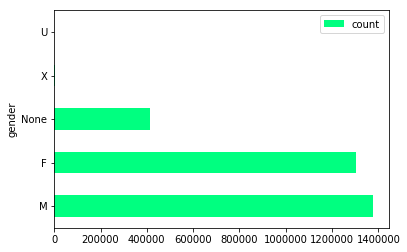

In [71]:
df_pandas_gender.plot(kind='barh', x='gender', y='count', colormap='winter_r')
plt.show()

In [ ]:
# Observation : There are lot of missing values for geneder column From above count it is apparent 
# that there are more number of Male travles than femal

In [ ]:
# Get the total number of travelers per type of visa

In [62]:
visa_type_df = i94_df.groupby('visatype').count().sort(col("count").desc())
df_pandas=visa_type_df.toPandas()
df_pandas


,visatype,count
0,WT,1309059
1,B2,1117897
2,WB,282983
3,B1,212410
4,GMT,89133
5,F1,39016
6,E2,19383
7,CP,14758
8,E1,3743
9,I,3176


# Visualize the data

In [55]:
df_pandas.plot(kind='barh', x='visatype', y='count', colormap='winter_r')
plt.show()

NameError: name 'df_pandas' is not defined

## Observation : From the above count it has been observed that there are more number of travelers visiting for Tourism, vacation, pleasure visitor with Visa type as B2. There are 210K B1 visa travelers coming for business tours, there is one category with WT which has hight count as per above visualization

In [19]:
from pyspark.sql.functions import desc
year_mth_number_travelers_df = i94_df.groupby('i94yr','i94mon','gender','arrdate','visatype').count().sort(desc("count")).show()
year_mth_number_travelers_df

+------+------+------+-------+--------+-----+
| i94yr|i94mon|gender|arrdate|visatype|count|
+------+------+------+-------+--------+-----+
|2016.0|   4.0|     F|20573.0|      WT|29799|
|2016.0|   4.0|     M|20573.0|      WT|27670|
|2016.0|   4.0|     F|20573.0|      B2|27200|
|2016.0|   4.0|     F|20574.0|      WT|26536|
|2016.0|   4.0|     F|20572.0|      B2|25705|
|2016.0|   4.0|     F|20574.0|      B2|24814|
|2016.0|   4.0|     M|20574.0|      WT|24174|
|2016.0|   4.0|     F|20566.0|      B2|23714|
|2016.0|   4.0|     F|20572.0|      WT|23648|
|2016.0|   4.0|     F|20565.0|      B2|22833|
|2016.0|   4.0|     F|20567.0|      WT|22370|
|2016.0|   4.0|     F|20545.0|      WT|22345|
|2016.0|   4.0|     M|20573.0|      B2|21956|
|2016.0|   4.0|     F|20560.0|      WT|21885|
|2016.0|   4.0|     F|20559.0|      B2|21843|
|2016.0|   4.0|     F|20546.0|      WT|21757|
|2016.0|   4.0|     F|20559.0|      WT|21616|
|2016.0|   4.0|     F|20566.0|      WT|21572|
|2016.0|   4.0|     F|20560.0|    

In [ ]:
# Most number of travelers traveled in the month of April.

In [20]:
# Find missing values
from pyspark.sql.functions import isnull, when, count, col
i94_missing_df = i94_df.select([count(when(isnull(c), c)).alias(c) for c in i94_df.columns]).toPandas()
i94_missing_df

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,0,0,0,0,0,0,0,239,152592,142457,...,3095921,138429,802,477,414269,2982605,83627,0,19549,0


# Loading World Temprature data

In [9]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = spark.read.csv(file_name, header=True, inferSchema=True)

In [10]:
temperature_df.limit(10).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E
9,1744-08-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [11]:
temperature_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [12]:
temperature_df.createOrReplaceTempView("GlobalLandTemperaturesByCity")

In [30]:
# visualize missing values by columns 
temperature_df2 = temperature_df.withColumn("DATE", F.split("dt",' ').getItem(0))\
                                .withColumn("TIME", F.split("dt",' ').getItem(1))\
                                .withColumn("AverageTemprature").cast("Double")
                                .drop("dt")


In [31]:
temperature_df2.limit(5).toPandas()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,DATE,TIME
0,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743-11-01,00:00:00
1,NaN,NaN,Århus,Denmark,57.05N,10.33E,1743-12-01,00:00:00
2,NaN,NaN,Århus,Denmark,57.05N,10.33E,1744-01-01,00:00:00
3,NaN,NaN,Århus,Denmark,57.05N,10.33E,1744-02-01,00:00:00
4,NaN,NaN,Århus,Denmark,57.05N,10.33E,1744-03-01,00:00:00


In [41]:
temperature_df2.select(["DATE", "TIME","AverageTemperature","AverageTemperatureUncertainty"]).show()

+----------+--------+-------------------+-----------------------------+
|      DATE|    TIME| AverageTemperature|AverageTemperatureUncertainty|
+----------+--------+-------------------+-----------------------------+
|1743-11-01|00:00:00|              6.068|           1.7369999999999999|
|1743-12-01|00:00:00|               null|                         null|
|1744-01-01|00:00:00|               null|                         null|
|1744-02-01|00:00:00|               null|                         null|
|1744-03-01|00:00:00|               null|                         null|
|1744-04-01|00:00:00| 5.7879999999999985|           3.6239999999999997|
|1744-05-01|00:00:00|             10.644|           1.2830000000000001|
|1744-06-01|00:00:00| 14.050999999999998|                        1.347|
|1744-07-01|00:00:00|             16.082|                        1.396|
|1744-08-01|00:00:00|               null|                         null|
|1744-09-01|00:00:00| 12.780999999999999|                       

In [33]:
# missing values from temprature data
from pyspark.sql.functions import isnull, when, count, col
nacounts = temperature_df.select([count(when(isnull(c), c)).alias(c) for c in temperature_df.columns]).toPandas()
nacounts

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,0,364130,364130,0,0,0,0


In [71]:
# Temprature data has 360K records with AverageTemperature and AverageTempratureUncertainity not present


<h1> Airport Codes Data</h1>

In [73]:
file_name="airport-codes_csv.csv"

In [76]:
airport_codes_df = spark.read.csv(file_name,inferSchema=True, header=True, sep=",")

In [77]:
airport_codes_df.limit(10).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"
5,00AS,small_airport,Fulton Airport,1100,NA,US,US-OK,Alex,00AS,None,00AS,"-97.8180194, 34.9428028"
6,00AZ,small_airport,Cordes Airport,3810,NA,US,US-AZ,Cordes,00AZ,None,00AZ,"-112.16500091552734, 34.305599212646484"
7,00CA,small_airport,Goldstone /Gts/ Airport,3038,NA,US,US-CA,Barstow,00CA,None,00CA,"-116.888000488, 35.350498199499995"
8,00CL,small_airport,Williams Ag Airport,87,NA,US,US-CA,Biggs,00CL,None,00CL,"-121.763427, 39.427188"
9,00CN,heliport,Kitchen Creek Helibase Heliport,3350,NA,US,US-CA,Pine Valley,00CN,None,00CN,"-116.4597417, 32.7273736"


In [46]:
airport = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("airport-codes_csv.csv")

In [47]:
airport.show(2)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
only showing top 2 rows



In [48]:
airport =   airport \
            .where(
            (col("iso_country") == "US") & (col("iata_code").isNotNull()) & (col("type").isin("large_airport", "medium_airport", "small_airport"))) \
            .withColumn("isoRegion", substring(col("iso_region"), 4, 2)) \
            .drop("local_code", "elevation_ft", "iso_region", 'continent') \
            .dropDuplicates()

In [49]:

print("Airport data schema:")
airport.printSchema()

Airport data schema:
root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- isoRegion: string (nullable = true)



In [53]:
airport_table = airport.select(['ident', 'type', 'name', 'isoRegion', 'municipality','gps_code', 'iata_code','iso_country', 'coordinates']) \
               .dropDuplicates().dropna()
parquet_check_n_create("_sas_data_air_port","dim_air_port.parquet")

FolderNameCheck:The _sas_data_air_port does exits...!! Using existing _sas_data_air_port
Nothing went wrong


# U.S. City Demographic Data: Data Description
## This data comes from OpenSoft and contains information about the demographics of all US ##cities and census-designated places with a population greater or equal to 65,000. ## Original data comes from the US Census Bureau's 2015 American Community Survey.

In [54]:
file_name = "us-cities-demographics.csv"
demographics_df = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')

In [70]:
# display the first five records
demographics_df.limit(10).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402
5,Peoria,Illinois,33.1,56229,62432,118661,6634,7517,2.40,IL,American Indian and Alaska Native,1343
6,Avondale,Arizona,29.1,38712,41971,80683,4815,8355,3.18,AZ,Black or African-American,11592
7,West Covina,California,39.8,51629,56860,108489,3800,37038,3.56,CA,Asian,32716
8,O'Fallon,Missouri,36.0,41762,43270,85032,5783,3269,2.77,MO,Hispanic or Latino,2583
9,High Point,North Carolina,35.5,51751,58077,109828,5204,16315,2.65,NC,Asian,11060


### Step 5: Complete Project Write Up
#### Rationale for the choice of tools and technologies for the project
        1. Apache spark was used because of:
        it's ability to handle multiple file formats with large amounts of data.
        Apache Spark offers a lightning-fast unified analytics engine for big data.
        Spark has easy-to-use APIs for operating on large datasets
        In addition to the above we can make use of Arrow for memory management
        2. Code readability,maintainability and familiarity is better with python as compare to Scala
        3. More Mature and time tested regarding data analytics and statistical libraries like numpy pandas, matplotlib and scikit-learn
        
        For the general purpose programming python is observed to be best option which can work 
        along with pyspark. 
        Note : Apache Spark might have memory limitations if the cluster size is not adequet in such         a cases using the AWS autoscaling during the processing might be the good solution.
        Propose how often the data should be updated and why.The current I94 immigration data is 
        updated Monthly however having it daily updated with incremental processing will help in reducing the full volume load every month
        
### Write a description of how you would approach the problem differently under the following scenarios:
   1. If the data loads are incremental the daily records processing incrementally will help in getting the less overhead due to applying the Type-2 processing and since daily processing may not invovle huge volume of data due to only considering the records for current day travelled travelers.
   2. For efficient storage we can make use of S3 buckets with Standard type, In addition the most recent data can be arived on S3 buckets and least frequently data can be moved to Infrequent accessed storage.
   3. In addition to the above we can also make use of AWS services such as AWS Redshift for ETL loads using the AWS Elasticache for analytical use.
   4. Test-driven approach is very useful in these scenarios
   5. Using broadcasting for the SMALL tables when joining with LARGE tables to each/machine node when you perform join df.join(broadcast(),[],how=left)